In [ ]:
import tensorflow as tf
from tensorflow import keras

import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds

In [ ]:
tf.config.list_physical_devices('GPU')   

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# 1. 데이터 불러오기 

In [ ]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split = ['train', 'test'], 
    as_supervised = True,
    shuffle_files = True,
    with_info = True
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/stanford_dogs/0.2.0.incompleteNT0K1H/stanford_dogs-train.tfrecord


  0%|          | 0/12000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/stanford_dogs/0.2.0.incompleteNT0K1H/stanford_dogs-test.tfrecord


  0%|          | 0/8580 [00:00<?, ? examples/s]

Dataset stanford_dogs downloaded and prepared to /root/tensorflow_datasets/stanford_dogs/0.2.0. Subsequent calls will reuse this data.


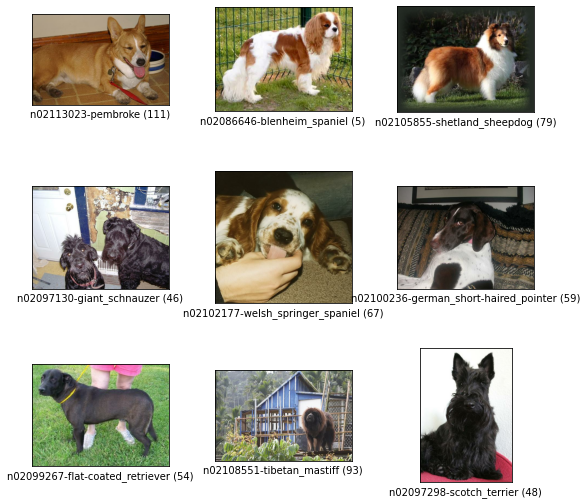

In [ ]:
fig = tfds.show_examples(ds_train, ds_info)

## 전처리 함수 만들기 

In [ ]:
# 기본적인 전처리 함수
def normalize_and_resize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

In [ ]:
def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta = 0.2) # max_delta는 float, must be non-negative.
    return image, label   

데이터 병렬화 : https://www.tensorflow.org/guide/data_performance?hl=ko
- num_parallel_calls, tf.data.experimental.AUTOTUNE, prefetch 등

In [ ]:
# 데이터셋(ds)을 가공하는 메인 함수 
def apply_normalize_on_dataset(ds, is_test = False, batch_size = 16, with_aug = False):
    ds = ds.map(
        normalize_and_resize_img,
        num_parallel_calls = 2    # map 변환을 병렬 처리
    )
    if not is_test and with_aug :
        ds = ds.map(
            augment,
            num_parallel_calls = 2
        )
    ds = ds.batch(batch_size)
    if not is_test :
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds 

In [ ]:
ds_train_no_aug = apply_normalize_on_dataset(ds_train, with_aug = False)

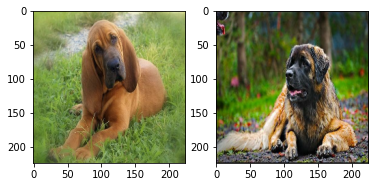

In [ ]:
for i, (image, label) in enumerate(ds_train_no_aug.take(1)) :
    if i == 0:
        image_a = image[0]
        image_b = image[1]
        label_a = label[0]
        label_b = label[1]
        break

plt.subplot(1,2,1)
plt.imshow(image_a)

plt.subplot(1,2,2)
plt.imshow(image_b)

# 2. CutMix

## tf.cast의 사용 방법
- tf.cast(변환할 텐서, 바꾸고 싶은 자료형)
- 배열의 dtype을 변경해주는 것
- ex) c1 = tf.cast(a1, tf.int32)  => a1을 int32형으로 바꿔준다

In [ ]:
def get_clip_box(image_a, image_b):
    image_size_x = image_a.shape[1]  
    image_size_y = image_a.shape[0]

    x = tf.cast( tf.random.uniform([], 0, image_size_x), tf.int32)
    y = tf.cast( tf.random.uniform([], 0, image_size_y), tf.int32)

    width = tf.cast(image_size_x * tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    height = tf.cast(image_size_y * tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)

    xa = tf.math.maximum(0, x - width // 2)
    ya = tf.math.maximum(0, y - height // 2)
    xb = tf.math.minimum(image_size_x, x + width // 2)
    yb = tf.math.minimum(image_size_y, y + width // 2)

    return xa, ya, xb, yb

xa, ya, xb, yb = get_clip_box(image_a, image_b)
print(xa, ya, xb, yb)

tf.Tensor(37, shape=(), dtype=int32) tf.Tensor(0, shape=(), dtype=int32) tf.Tensor(133, shape=(), dtype=int32) tf.Tensor(122, shape=(), dtype=int32)


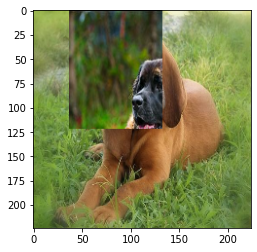

In [ ]:
def mix_2_images(image_a, image_b, xa, ya, xb, yb):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0]
    one = image_a[ya:yb,0:xa,:]
    two = image_b[ya:yb,xa:xb,:]
    three = image_a[ya:yb,xb:image_size_x,:]
    middle = tf.concat([one,two,three],axis=1)
    top = image_a[0:ya,:,:]
    bottom = image_a[yb:image_size_y,:,:]
    mixed_img = tf.concat([top, middle, bottom],axis=0)
    
    return mixed_img

mixed_img = mix_2_images(image_a, image_b, xa, ya, xb, yb)
plt.imshow(mixed_img.numpy())

In [ ]:
def mix_2_label(label_a, label_b, xa, ya, xb, yb, num_classes=120):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    mixed_area = (xb-xa)*(yb-ya)
    total_area = image_size_x*image_size_y
    a = tf.cast(mixed_area/total_area, tf.float32)

    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_label = (1-a)*label_a + a*label_b
    return mixed_label

mixed_label = mix_2_label(label_a, label_b, xa, ya, xb, yb)
mixed_label

<tf.Tensor: shape=(120,), dtype=float32, numpy=
array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.76658165, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.     

In [ ]:
def cutmix(image, label, prob = 1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_b = image[j]
        label_b = label[j]
        xa, ya, xb, yb = get_clip_box(image_a, image_b)
        mixed_imgs.append(mix_2_images(image_a, image_b, xa, ya, xb, yb))
        mixed_labels.append(mix_2_label(label_a, label_b, xa, ya, xb, yb))

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs),(batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels),(batch_size, num_classes))
    return mixed_imgs, mixed_labels

In [ ]:
num_classes = ds_info.features["label"].num_classes
num_classes

120

# 3. Mixup

tf.Tensor(
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.64657533 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         

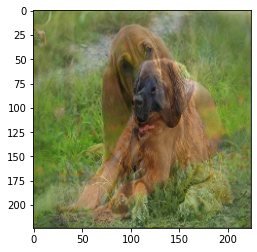

In [ ]:
def mixup_2_images(image_a, image_b, label_a, label_b):
    a = tf.random.uniform([],0,1)
    
    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_image= (1-a)*image_a + a*image_b
    mixed_label = (1-a)*label_a + a*label_b
    
    return mixed_image, mixed_label

mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
plt.imshow(mixed_img.numpy())
print(mixed_label)

In [ ]:
def mixup(image, label, prob = 1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_b = image[j]
        label_b = label[j]
        mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
        mixed_imgs.append(mixed_img)
        mixed_labels.append(mixed_label)

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs),(batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels),(batch_size, num_classes))
    return mixed_imgs, mixed_labels

In [ ]:
def onehot(image, label) :
    label = tf.one_hot(label, num_classes)
    return image, label

In [ ]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False, with_cutmix=False, with_mixup=False):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    if not is_test and with_aug:
        ds = ds.map(
            augment
        )
    ds = ds.batch(batch_size)
    if not is_test and with_cutmix:
        ds = ds.map(
            cutmix,
            num_parallel_calls=2
        )
    elif not is_test and with_mixup:
        ds = ds.map(
            mixup,
            num_parallel_calls=2
        )
    else:
        ds = ds.map(
            onehot,
            num_parallel_calls=2
        )
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [ ]:
ds_train_no_aug = apply_normalize_on_dataset(ds_train, with_aug = False)
ds_train_aug = apply_normalize_on_dataset(ds_train, with_aug=True)
ds_train_cutmix = apply_normalize_on_dataset(ds_train, with_cutmix = True)
ds_train_mixup = apply_normalize_on_dataset(ds_train, with_mixup = True)
ds_test = apply_normalize_on_dataset(ds_test, is_test = True)

In [ ]:
resnet50_no_aug = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top = False,
        weights = 'imagenet',
        input_shape = (224, 224, 3),
        pooling = 'avg'
    ), 
    keras.layers.Dense(num_classes, activation = 'softmax')
])

94781440/94765736 [==============================] - 1s 0us/step


In [ ]:
resnet50_aug = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top = False,
        weights = 'imagenet',
        input_shape = (224, 224, 3),
        pooling = 'avg'
    ),
    keras.layers.Dense(num_classes, activation = 'softmax')
])

In [ ]:
resnet50_cutmix = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top = False, 
        weights = 'imagenet',
        input_shape = (224, 224, 3),
        pooling = 'avg',
    ), 
    keras.layers.Dense(num_classes, activation = 'softmax')
])

In [ ]:
resnet50_cutmix = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top = False, 
        weights = 'imagenet',
        input_shape = (224, 224, 3),
        pooling = 'avg',
    ),
    keras.layers.Dense(num_classes, activation = 'softmax')
])

In [ ]:
resnet50_mixup = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top = False,
        weights = 'imagenet',
        input_shape = (224, 224, 3),
        pooling = 'avg',
    ),
    keras.layers.Dense(num_classes, activation = 'softmax')
])

In [ ]:
EPOCH = 20  # Augemtation 적용 효과를 확인하기 위해 필요한 epoch 수

tf.random.set_seed(2021)
resnet50_no_aug.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

resnet50_aug.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

resnet50_cutmix.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

resnet50_mixup.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [ ]:
history_resnet50_no_aug = resnet50_no_aug.fit(
    ds_train_no_aug,
    steps_per_epoch = int(ds_info.splits['train'].num_examples/16),
    validation_steps = int(ds_info.splits['test'].num_examples/16),
    epochs = EPOCH,
    validation_data = ds_test,
    verbose = 1,
    use_multiprocessing = True,
)

Epoch 1/20
750/750 [==============================] - 108s 122ms/step - loss: 2.2019 - accuracy: 0.4454 - val_loss: 3.4067 - val_accuracy: 0.1989
Epoch 2/20
750/750 [==============================] - 90s 119ms/step - loss: 0.7782 - accuracy: 0.7850 - val_loss: 1.2157 - val_accuracy: 0.6466
Epoch 3/20
750/750 [==============================] - 91s 121ms/step - loss: 0.3032 - accuracy: 0.9285 - val_loss: 0.9881 - val_accuracy: 0.7123
Epoch 4/20
750/750 [==============================] - 91s 121ms/step - loss: 0.0893 - accuracy: 0.9889 - val_loss: 0.9342 - val_accuracy: 0.7343
Epoch 5/20
750/750 [==============================] - 90s 121ms/step - loss: 0.0404 - accuracy: 0.9973 - val_loss: 0.9214 - val_accuracy: 0.7347
Epoch 6/20
750/750 [==============================] - 90s 120ms/step - loss: 0.0165 - accuracy: 0.9993 - val_loss: 0.9173 - val_accuracy: 0.7441
Epoch 7/20
750/750 [==============================] - 90s 120ms/step - loss: 0.0094 - accuracy: 1.0000 - val_loss: 0.9257 - val_a

In [ ]:
history_resnet50_aug = resnet50_aug.fit(
    ds_train_aug,
    steps_per_epoch = int(ds_info.splits['train'].num_examples/16),
    validation_steps = int(ds_info.splits['test'].num_examples/16),
    epochs = EPOCH,
    validation_data = ds_test,
    verbose = 1,
    use_multiprocessing = True,
)

Epoch 1/20
750/750 [==============================] - 99s 121ms/step - loss: 2.2476 - accuracy: 0.4384 - val_loss: 3.0432 - val_accuracy: 0.2607
Epoch 2/20
750/750 [==============================] - 90s 120ms/step - loss: 0.8882 - accuracy: 0.7456 - val_loss: 1.2413 - val_accuracy: 0.6410
Epoch 3/20
750/750 [==============================] - 90s 121ms/step - loss: 0.4315 - accuracy: 0.8872 - val_loss: 1.0279 - val_accuracy: 0.6985
Epoch 4/20
750/750 [==============================] - 90s 120ms/step - loss: 0.2339 - accuracy: 0.9453 - val_loss: 1.1047 - val_accuracy: 0.6916
Epoch 5/20
750/750 [==============================] - 95s 126ms/step - loss: 0.1037 - accuracy: 0.9843 - val_loss: 0.9988 - val_accuracy: 0.7226
Epoch 6/20
750/750 [==============================] - 92s 122ms/step - loss: 0.0553 - accuracy: 0.9934 - val_loss: 0.9798 - val_accuracy: 0.7253
Epoch 7/20
750/750 [==============================] - 91s 122ms/step - loss: 0.0321 - accuracy: 0.9965 - val_loss: 0.9801 - val_ac

In [ ]:
history_resnet50_cutmix = resnet50_cutmix.fit(
    ds_train_cutmix,
    steps_per_epoch = int(ds_info.splits['train'].num_examples/16),
    validation_steps = int(ds_info.splits['test'].num_examples/16),
    epochs = EPOCH,
    validation_data = ds_test,
    verbose = 1,
    use_multiprocessing = True,
)

Epoch 1/20
750/750 [==============================] - 101s 123ms/step - loss: 3.8125 - accuracy: 0.2227 - val_loss: 3.3886 - val_accuracy: 0.2001
Epoch 2/20
750/750 [==============================] - 91s 121ms/step - loss: 2.9554 - accuracy: 0.4342 - val_loss: 1.5542 - val_accuracy: 0.5759
Epoch 3/20
750/750 [==============================] - 91s 121ms/step - loss: 2.6541 - accuracy: 0.5241 - val_loss: 1.4881 - val_accuracy: 0.5823
Epoch 4/20
750/750 [==============================] - 91s 121ms/step - loss: 2.4267 - accuracy: 0.5986 - val_loss: 1.1665 - val_accuracy: 0.6825
Epoch 5/20
750/750 [==============================] - 91s 121ms/step - loss: 2.2544 - accuracy: 0.6565 - val_loss: 1.1468 - val_accuracy: 0.6790
Epoch 6/20
750/750 [==============================] - 91s 121ms/step - loss: 2.1450 - accuracy: 0.6888 - val_loss: 1.1893 - val_accuracy: 0.6810
Epoch 7/20
750/750 [==============================] - 91s 121ms/step - loss: 2.0452 - accuracy: 0.7141 - val_loss: 1.2043 - val_a

In [ ]:
history_resnet50_mixup = resnet50_mixup.fit(
    ds_train_mixup,
    steps_per_epoch = int(ds_info.splits['train'].num_examples/16),
    validation_steps = int(ds_info.splits['test'].num_examples/16),
    epochs = EPOCH,
    validation_data = ds_test,
)

Epoch 1/20
750/750 [==============================] - 100s 122ms/step - loss: 3.7594 - accuracy: 0.2334 - val_loss: 4.1147 - val_accuracy: 0.1066
Epoch 2/20
750/750 [==============================] - 91s 121ms/step - loss: 2.8585 - accuracy: 0.4799 - val_loss: 1.5928 - val_accuracy: 0.5562
Epoch 3/20
750/750 [==============================] - 91s 122ms/step - loss: 2.5792 - accuracy: 0.5792 - val_loss: 1.5768 - val_accuracy: 0.5619
Epoch 4/20
750/750 [==============================] - 95s 127ms/step - loss: 2.3807 - accuracy: 0.6582 - val_loss: 1.3463 - val_accuracy: 0.6316
Epoch 5/20
750/750 [==============================] - 91s 122ms/step - loss: 2.2453 - accuracy: 0.7124 - val_loss: 1.2210 - val_accuracy: 0.6617
Epoch 6/20
750/750 [==============================] - 91s 121ms/step - loss: 2.1391 - accuracy: 0.7492 - val_loss: 1.2239 - val_accuracy: 0.6657
Epoch 7/20
750/750 [==============================] - 91s 122ms/step - loss: 2.0822 - accuracy: 0.7763 - val_loss: 1.2220 - val_a

In [ ]:
plt.figure(figsize = (12, 8))
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'b')
plt.plot(history_resnet50_cutmix.history['val_accuracy'], 'g')
plt.plot(history_resnet50_mixup.history['val_accuracy'], 'k')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation', 'With CutMix', 'With Mixup'], loc = 'lower right')
plt.grid(True)
plt.show()

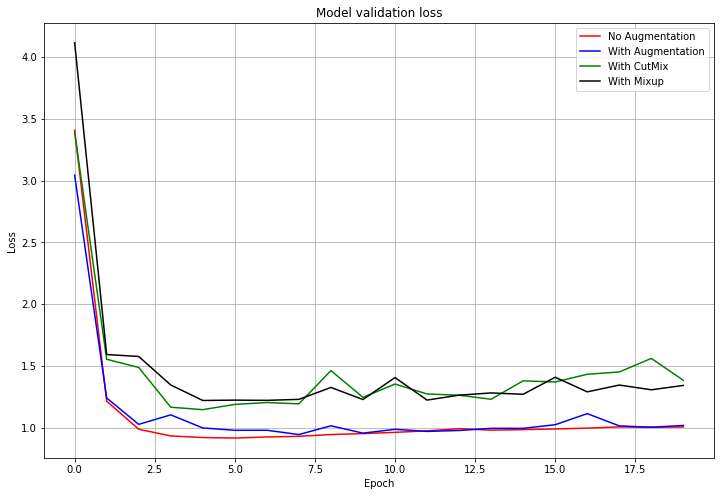

In [ ]:
plt.figure(figsize = (12, 8))
plt.plot(history_resnet50_no_aug.history['val_loss'], 'r')
plt.plot(history_resnet50_aug.history['val_loss'], 'b')
plt.plot(history_resnet50_cutmix.history['val_loss'], 'g')
plt.plot(history_resnet50_mixup.history['val_loss'], 'k')
plt.title('Model validation loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation', 'With CutMix', 'With Mixup'], loc = 'upper right')
plt.grid(True)
plt.show()

In [ ]:
import pandas as pd

acc_data = {'No Augmentation' : history_resnet50_no_aug.history['val_accuracy'],
            'With Augmentation' : history_resnet50_aug.history['val_accuracy'],
            'With CutMix' : history_resnet50_cutmix.history['val_accuracy'],
            'With Mixup' : history_resnet50_mixup.history['val_accuracy']}
acc_df = pd.DataFrame(acc_data)
acc_df

,No Augmentation,With Augmentation,With CutMix,With Mixup
0,0.198927,0.260728,0.200093,0.106576
1,0.646572,0.640975,0.575909,0.556203
2,0.712337,0.698461,0.582323,0.561917
3,0.734258,0.691581,0.682486,0.631646
4,0.734725,0.722598,0.678988,0.661730
5,0.744053,0.725280,0.680970,0.665695
6,0.744286,0.731810,0.678988,0.661381
7,0.743354,0.742304,0.694846,0.678755
8,0.743237,0.733209,0.635611,0.643890
9,0.743354,0.745103,0.680270,0.678871


# 회고
- augmentation의 유무를 비교하였을 때 적용한 것이 안한 것보다 조금 더 성능이 좋아진 것을 볼 수 있다. 
    - 조금 더 다양한 이미지가 입력되어서 정확도에 긍정적인 영향을 준 것 같다
- cutmix와 mixup이 적용된 결과를 보면 정확도가 낮은 것을 볼 수 있다 - 일단 cutmix와 mixup의 결과물을 보면 정확도가 왜 낮게 나왔는지 예상할 수 있는데 두 결과물 자체가 좀 일반적이지 않고 노이즈처럼 관계없는 이미지 결과물로 나왔다. 
- 이상한 결과물로 학습에 사용을 하니 당연히 정확도도 낮게 나오는 것이 아닌가 라는 생각이 들었고 굳이 cutmix, mixup을 왜 사용하는가 궁금증이 생겼다 


# 참고
- cutmix, mixup : https://hongl.tistory.com/223
- https://github.com/kec0130/AIFFEL-project/blob/main/goingdeeper/G4_data_augmentation_pjt.ipynb